# Description

* Quality control on MiSeq run data
  * post-merging
  * post-demultiplexing

# Setting variables

In [1]:
import os

baseDir = '/home/seq_data/fullCyc2/amplicon/515F-806R/final_dataset/library_QC/fullCyc2_lib3'
workDir = os.path.join(baseDir, 'QC')
seqFile = os.path.join(baseDir, 'pear_merged-fullCyc2_lib3.assembled.dmult.fastq')

# number of processors
nprocs = 10

# max expected error
maxee = 1

# Init

In [2]:
import re
import pandas as pd

In [3]:
%load_ext rpy2.ipython
#%load_ext pushnote

In [4]:
%%R
library(ggplot2)
library(dplyr)
library(tidyr)
library(gridExtra)

/home/sam/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: 
Attaching package: ‘dplyr’


  warnings.warn(x, RRuntimeWarning)
/home/sam/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  warnings.warn(x, RRuntimeWarning)
/home/sam/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  warnings.warn(x, RRuntimeWarning)
/home/sam/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: 
Attaching package: ‘gridExtra’


  warnings.warn(x, RRuntimeWarning)
/home/sam/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: The following object is masked from ‘package:dplyr’:

    combine


  warnings.warn(x, RRuntimeWarning)


In [5]:
if not os.path.isdir(workDir):
    os.makedirs(workDir)
%cd $workDir

/home/seq_data/fullCyc2/amplicon/515F-806R/final_dataset/library_QC/fullCyc2_lib3/QC


In [6]:
# symlinking demult seq file into CQ
tmp = os.path.join(baseDir, seqFile)
if not os.path.isfile(seqFile):
    tmp2 = os.path.split(tmp)[1]
    os.symlink(tmp, tmp2)
else:
    print ('File exists: {}'.format(os.path.join(workDir, seqFile)))

File exists: /home/seq_data/fullCyc2/amplicon/515F-806R/final_dataset/library_QC/fullCyc2_lib3/pear_merged-fullCyc2_lib3.assembled.dmult.fastq


# Merged read quality filtering

## Discard sequences that exceed max expected error theshold

In [7]:
qcFile = os.path.split(seqFile)[1]
qcFile = os.path.splitext(qcFile)[0] + '_maxee{}.fasta'.format(maxee)
qcFile

'pear_merged-fullCyc2_lib3.assembled.dmult_maxee1.fasta'

In [8]:
%%bash -s "$seqFile" "$nprocs" "$maxee" "$qcFile"

mkdir /home/sam/tmp/tmpdir1
trap "rm -r /home/sam/tmp/tmpdir1" 1 2 3 15
split -d -l 2000000 $1 /home/sam/tmp/tmpdir1/Block

mkdir /home/sam/tmp/tmpdir2
trap "rm -r /home/sam/tmp/tmpdir2" 1 2 3 15
ls /home/sam/tmp/tmpdir1/Block?? | parallel --gnu -j $2 -k "usearch -fastq_filter {} -fastq_maxee $3 \
-fastaout /home/sam/tmp/tmpdir2/{#}.fasta >/dev/null 2>&1 && cat /home/sam/tmp/tmpdir2/{#}.fasta" > $4
rm -r /home/sam/tmp/tmpdir2 /home/sam/tmp/tmpdir1

In [9]:
%%bash -s "$seqFile" "$nprocs" "$maxee" "$qcFile"

printf "Max expected error cutoff: "
echo $3

printf "Number of sequence pre-filter: "
grep -c "orig_name=" $1

printf "Number of sequences post-filter: "
grep -c ">" $4

echo '' 
head -n 8 $4

Max expected error cutoff: 1
Number of sequence pre-filter: 5176899
Number of sequences post-filter: 5122226

>MR.M.13C-Ami.D6.R1_Frac17_0 orig_name=M01032:435:000000000-ATCM8:1:1101:17785:1816
TACGGAGGGGGCTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCGCGGAGGCGGCGTTGCAAGTTAGAGGGGAAAGCCC
GGGGCTTAACTCCGGAACTGCCTTTAAAACTGCATCGCTAGAGTTCGGGAGAGGAGAGTGGAATTCCCGGTGTAGAGGTG
AAATTCGGAGATATTGGGAAGAACACCGGGGGCGAAGGCGGCGCACTGGACCGAAACTGACGCTGAGGCGCGAAAGCGAG
GGGAGCAAACAGG
>MR.A.12C-Con.D30.R3_Frac18_2 orig_name=M01032:435:000000000-ATCM8:1:1101:18010:1845
TACGGAGGGGGCTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCACGTAGGCGGCTTTGTAAGTTAGAGGGGAAAGCCT
GGCGCTCAACCCCGGTACTGCCTTTAAGACTGCCTCGCTTGAATCATGGAGAGGCGGGTGGAATTCCGGGTGTAGAGGTG


## Remove seqs with 'N' characters

In [10]:
qcFile2 = os.path.splitext(qcFile)[0] + '_noN.fasta'
qcFile2

'pear_merged-fullCyc2_lib3.assembled.dmult_maxee1_noN.fasta'

In [11]:
%%bash -s "$qcFile" "$qcFile2"

bioawk -c fastx '{if ($seq !~ /N/){print ">" $name " " $4 "\n" $seq}}' $1 > $2

printf "Number of sequence pre-filter: "
grep -c ">" $1

printf "Number of sequences post-filter: "
grep -c ">" $2

Number of sequence pre-filter: 5122226
Number of sequences post-filter: 5122226


## Alignment-based QC with Mothur

In [12]:
%%bash -s "$qcFile2"
# making mothur group file

perl -ne 'if(/^>/){ s/>(.+)(_\d+) .+/$1$2\t$1/; print;}' $1 > group_file.txt
head group_file.txt

MR.M.13C-Ami.D6.R1_Frac17_0	MR.M.13C-Ami.D6.R1_Frac17
MR.A.12C-Con.D30.R3_Frac18_2	MR.A.12C-Con.D30.R3_Frac18
MR.F.13C-Xyl.D6.R1_Frac28_7	MR.F.13C-Xyl.D6.R1_Frac28
MR.M.13C-Ami.D6.R1_Frac10_8	MR.M.13C-Ami.D6.R1_Frac10
MR.F.13C-Xyl.D6.R1_Frac20_10	MR.F.13C-Xyl.D6.R1_Frac20
MR.A.12C-Con.D30.R3_Frac5_9	MR.A.12C-Con.D30.R3_Frac5
MR.F.13C-Cel.D14.R2_Frac15_12	MR.F.13C-Cel.D14.R2_Frac15
MR.M.12C-Con.D6.R2_Frac18_14	MR.M.12C-Con.D6.R2_Frac18
MR.F.13C-Xyl.D6.R1_Frac18_16	MR.F.13C-Xyl.D6.R1_Frac18
MR.M.13C-Ami.D6.R1_Frac23_19	MR.M.13C-Ami.D6.R1_Frac23


In [13]:
! head -n 200 group_file.txt

MR.M.13C-Ami.D6.R1_Frac17_0	MR.M.13C-Ami.D6.R1_Frac17
MR.A.12C-Con.D30.R3_Frac18_2	MR.A.12C-Con.D30.R3_Frac18
MR.F.13C-Xyl.D6.R1_Frac28_7	MR.F.13C-Xyl.D6.R1_Frac28
MR.M.13C-Ami.D6.R1_Frac10_8	MR.M.13C-Ami.D6.R1_Frac10
MR.F.13C-Xyl.D6.R1_Frac20_10	MR.F.13C-Xyl.D6.R1_Frac20
MR.A.12C-Con.D30.R3_Frac5_9	MR.A.12C-Con.D30.R3_Frac5
MR.F.13C-Cel.D14.R2_Frac15_12	MR.F.13C-Cel.D14.R2_Frac15
MR.M.12C-Con.D6.R2_Frac18_14	MR.M.12C-Con.D6.R2_Frac18
MR.F.13C-Xyl.D6.R1_Frac18_16	MR.F.13C-Xyl.D6.R1_Frac18
MR.M.13C-Ami.D6.R1_Frac23_19	MR.M.13C-Ami.D6.R1_Frac23
MR.F.13C-Xyl.D3.R1_Frac22_21	MR.F.13C-Xyl.D3.R1_Frac22
MR.F.13C-Xyl.D6.R1_Frac17_22	MR.F.13C-Xyl.D6.R1_Frac17
MR.M.13C-Ami.D6.R1_Frac16_23	MR.M.13C-Ami.D6.R1_Frac16
MR.F.13C-Xyl.D3.R1_Frac7_24	MR.F.13C-Xyl.D3.R1_Frac7
MR.F.12C-Con.D14.R1_Frac18_25	MR.F.12C-Con.D14.R1_Frac18
MR.M.12C-Con.D6.R2_Frac23_30	MR.M.12C-Con.D6.R2_Frac23
MR.M.12C-Con.D6.R2_Frac8_27	MR.M.12C-Con.D6.R2_Frac8
MR.F.13C-Xyl.D6.R1_Frac9_26	MR.F.13C-Xyl.D6.R1_Frac9
MR.M.13C-Ami.D6

In [14]:
# unique sequences
cmd = 'mothur "#unique.seqs(fasta={})"'.format(qcFile2)
!$cmd | tail -n 30

5101000	3009833
5102000	3010253
5103000	3010690
5104000	3011121
5105000	3011569
5106000	3012022
5107000	3012512
5108000	3012993
5109000	3013452
5110000	3013922
5111000	3014403
5112000	3014924
5113000	3015398
5114000	3015905
5115000	3016427
5116000	3016952
5117000	3017537
5118000	3018079
5119000	3018625
5120000	3019152
5121000	3019687
5122000	3020284
5122226	3020406

Output File Names: 
pear_merged-fullCyc2_lib3.assembled.dmult_maxee1_noN.names
pear_merged-fullCyc2_lib3.assembled.dmult_maxee1_noN.unique.fasta


mothur > quit()


In [15]:
qcFile3 = os.path.splitext(qcFile2)[0] + '.unique.fasta'
n_uniq = !grep -c ">" $qcFile3
print ('Number of unique sequences: {}'.format(n_uniq[0]))

Number of unique sequences: 3020406


In [16]:
# name file produced by unique.seqs()
nameFile = os.path.splitext(qcFile2)[0] + '.names'
!ls -thlc $nameFile

-rw-rw-r-- 1 sam sam 264M May 15 14:34 pear_merged-fullCyc2_lib3.assembled.dmult_maxee1_noN.names


In [17]:
%%bash 
# Remove database if already exsists
if [ -d mothur_silva_db ]; then
    rm -rf mothur_silva_db
fi

#if ! [ -d mothur_silva_db ]; then
#    mkdir mothur_silva_db
#fi

mkdir mothur_silva_db
cd mothur_silva_db

# Download mothur recreatd SEED database release 132.
wget https://www.mothur.org/w/images/7/71/Silva.seed_v132.tgz
#wget https://www.mothur.org/w/images/a/a4/Silva.seed_v128.tgz
tar -xvzf Silva.seed_v132.tgz
rm Silva.seed_v132.tgz

silva.seed_v132.tax
silva.seed_v132.align
README.md


--2018-05-15 14:34:45--  https://www.mothur.org/w/images/7/71/Silva.seed_v132.tgz
Resolving www.mothur.org (www.mothur.org)... 141.214.120.22
Connecting to www.mothur.org (www.mothur.org)|141.214.120.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19623900 (19M) [application/x-gzip]
Saving to: ‘Silva.seed_v132.tgz’

     0K .......... .......... .......... .......... ..........  0% 1.89M 10s
    50K .......... .......... .......... .......... ..........  0%  997K 14s
   100K .......... .......... .......... .......... ..........  0% 1.86M 13s
   150K .......... .......... .......... .......... ..........  1%  997K 14s
   200K .......... .......... .......... .......... ..........  1% 1.87M 13s
   250K .......... .......... .......... .......... ..........  1% 1000K 14s
   300K .......... .......... .......... .......... ..........  1%  990K 15s
   350K .......... .......... .......... .......... ..........  2% 1.90M 14s
   400K .......... .......... .......

In [18]:
silvaFile = 'silva.seed_v132.align'
cmd = 'mothur "#filter.seqs(vertical=t, fasta={}, processors={})"'.format(silvaFile, nprocs)
!cd mothur_silva_db; $cmd | tail -n 20

silvaFileFilt = os.path.splitext(silvaFile)[0] + '.filter.fasta'
silvaFileFilt = os.path.join('mothur_silva_db', silvaFileFilt)
ret = !grep -c ">" $silvaFileFilt
print ('\nNumber of sequences post-filter: {}'.format(ret[0]))

700
800
900
1000
1100
1118



Length of filtered alignment: 10180
Number of columns removed: 39820
Length of the original alignment: 50000
Number of sequences used to construct filter: 11180

Output File Names: 
silva.filter
silva.seed_v132.filter.fasta


mothur > quit()

Number of sequences post-filter: 11180


In [19]:
# aligning sequences
qcFile3a = re.sub('-', '\-', qcFile3)
cmd = 'mothur "#align.seqs(candidate={}, template={}, processors={}, flip=T)"'.format(qcFile3a, silvaFileFilt, nprocs)
!$cmd | tail -n 30

302100
302200
302300
302400
302500
302600
302700
302800
302900
302992
[WARNING]: Some of your sequences generated alignments that eliminated too many bases, a list is provided in pear_merged-fullCyc2_lib3.assembled.dmult_maxee1_noN.unique.flip.accnos. If the reverse compliment proved to be better it was reported.
It took 1981 secs to align 3020406 sequences.


Output File Names: 
pear_merged-fullCyc2_lib3.assembled.dmult_maxee1_noN.unique.align
pear_merged-fullCyc2_lib3.assembled.dmult_maxee1_noN.unique.align.report
pear_merged-fullCyc2_lib3.assembled.dmult_maxee1_noN.unique.flip.accnos


mothur > quit()


<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<^>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<^>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<^>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Detected 1 [WARNING] messages, please review.
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<^>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<^>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<^>>>>

In [20]:
qcFile4 = os.path.splitext(qcFile3)[0] + '.align'
!ls -thlc $qcFile4 

-rw-rw-r-- 1 sam sam 29G May 15 15:08 pear_merged-fullCyc2_lib3.assembled.dmult_maxee1_noN.unique.align


In [21]:
# filtering out gap positions in the alignment
qcFile4a = re.sub('-', '\-', qcFile4)
cmd = 'mothur "#filter.seqs(vertical=t, fasta={}, processors={})"'.format(qcFile4a, nprocs)
!$cmd | tail -n 30

300600
300700
300800
300900
301000
301100
301200
301300
301400
301500
301600
301700
301800
301900
302000
302072



Length of filtered alignment: 1401
Number of columns removed: 8779
Length of the original alignment: 10180
Number of sequences used to construct filter: 3020406

Output File Names: 
pear_merged-fullCyc2_lib3.filter
pear_merged-fullCyc2_lib3.assembled.dmult_maxee1_noN.unique.filter.fasta


mothur > quit()


In [22]:
qcFile5 = os.path.splitext(qcFile3)[0] + '.filter.fasta'
!ls -thlc $qcFile5

-rw-rw-r-- 1 sam sam 4.1G May 15 15:10 pear_merged-fullCyc2_lib3.assembled.dmult_maxee1_noN.unique.filter.fasta


In [23]:
cmd = 'mothur "#summary.seqs(fasta={}, processors={}, name={})"'.format(qcFile5, nprocs, nameFile)
!$cmd | tail -n 20

Using 10 processors.

		Start	End	NBases	Ambigs	Polymer	NumSeqs
Minimum:	0	0	0	0	1	1
2.5%-tile:	228	1085	253	0	4	128056
25%-tile:	228	1085	253	0	4	1280557
Median: 	228	1085	253	0	5	2561114
75%-tile:	228	1085	253	0	6	3841670
97.5%-tile:	228	1085	254	0	8	4994171
Maximum:	1401	1401	361	0	135	5122226
Mean:	229.29	1084.99	252.687	0	5.09312
# of unique seqs:	3020406
total # of seqs:	5122226

Output File Names: 
pear_merged-fullCyc2_lib3.assembled.dmult_maxee1_noN.unique.filter.summary

It took 25 secs to summarize 5122226 sequences.

mothur > quit()


## Removing homopolymers (> 8) and screening out sequences that don't align to an amplicon region

In [24]:
cmd = """mothur '#screen.seqs(fasta={},\
    processors={},\
    name={},\
    group={},\
    start={},\
    end={},\
    maxhomop=8)'""".format(qcFile5, nprocs, nameFile, 'group_file.txt', 228, 1085)
!$cmd | tail -n 30

Processing sequence: 300500
Processing sequence: 300600
Processing sequence: 300700
Processing sequence: 300800
Processing sequence: 300900
Processing sequence: 301000
Processing sequence: 301100
Processing sequence: 301200
Processing sequence: 301300
Processing sequence: 301400
Processing sequence: 301500
Processing sequence: 301600
Processing sequence: 301700
Processing sequence: 301800
Processing sequence: 301900
Processing sequence: 302000
Processing sequence: 302100
Processing sequence: 302200
Processing sequence: 302258

Output File Names: 
pear_merged-fullCyc2_lib3.assembled.dmult_maxee1_noN.unique.filter.good.fasta
pear_merged-fullCyc2_lib3.assembled.dmult_maxee1_noN.unique.filter.bad.accnos
pear_merged-fullCyc2_lib3.assembled.dmult_maxee1_noN.good.names
group_file.good.txt


It took 48 secs to screen 3020406 sequences.

mothur > quit()


In [25]:
qcFile6 = os.path.splitext(qcFile5)[0] + '.good.fasta'
ret = !grep -c ">" $qcFile6
print ('Number of sequences post-filter: {}'.format(ret[0]))

Number of sequences post-filter: 2950125


In [26]:
qcFile6a = re.sub('-', '\-', qcFile6)
cmd = 'mothur "#filter.seqs(fasta={}, processors={}, vertical=T)"'.format(qcFile6a, nprocs)
!$cmd | tail -n 20

294800
294900
295000
295100
295200
295225



Length of filtered alignment: 951
Number of columns removed: 450
Length of the original alignment: 1401
Number of sequences used to construct filter: 2950125

Output File Names: 
pear_merged-fullCyc2_lib3.filter
pear_merged-fullCyc2_lib3.assembled.dmult_maxee1_noN.unique.filter.good.filter.fasta


mothur > quit()


In [27]:
qcFile7 = os.path.splitext(qcFile6)[0] + '.filter.fasta'
!ls -thlc $qcFile7

-rw-rw-r-- 1 sam sam 2.8G May 15 15:13 pear_merged-fullCyc2_lib3.assembled.dmult_maxee1_noN.unique.filter.good.filter.fasta


## Deunique seqs

In [28]:
cmd = 'mothur "#deunique.seqs(fasta={}, name={})"'.format(qcFile7, nameFile)
!$cmd | tail -n 30

mothur v.1.39.5
Last updated: 3/20/2017

by
Patrick D. Schloss

Department of Microbiology & Immunology
University of Michigan
http://www.mothur.org

When using, please cite:
Schloss, P.D., et al., Introducing mothur: Open-source, platform-independent, community-supported software for describing and comparing microbial communities. Appl Environ Microbiol, 2009. 75(23):7537-41.

Distributed under the GNU General Public License

Type 'help()' for information on the commands that are available

For questions and analysis support, please visit our forum at https://www.mothur.org/forum

Type 'quit()' to exit program



mothur > deunique.seqs(fasta=pear_merged-fullCyc2_lib3.assembled.dmult_maxee1_noN.unique.filter.good.filter.fasta, name=pear_merged-fullCyc2_lib3.assembled.dmult_maxee1_noN.names)

Output File Names: 
pear_merged-fullCyc2_lib3.assembled.dmult_maxee1_noN.unique.filter.good.filter.redundant.fasta


mothur > quit()


### Final QC-ed file

In [29]:
qcFile8 = os.path.splitext(qcFile7)[0] + '.redundant.fasta'
qcFinal = 'finalQC.fasta'
!perl -pe 's/[-.]//g if ! /^>/' $qcFile8 > $qcFinal

In [30]:
cmd = 'mothur "#summary.seqs(fasta={}, processors={})"'.format(qcFinal, nprocs)
!$cmd | tail -n 20


Using 10 processors.

		Start	End	NBases	Ambigs	Polymer	NumSeqs
Minimum:	1	218	218	0	3	1
2.5%-tile:	1	253	253	0	4	125442
25%-tile:	1	253	253	0	4	1254411
Median: 	1	253	253	0	5	2508821
75%-tile:	1	253	253	0	6	3763231
97.5%-tile:	1	254	254	0	8	4892200
Maximum:	1	340	340	0	8	5017640
Mean:	1	253.057	253.057	0	5.07327
# of Seqs:	5017640

Output File Names: 
finalQC.summary

It took 7 secs to summarize 5017640 sequences.

mothur > quit()


In [31]:
!head -n 6 $qcFinal

>MR.M.13C-Ami.D6.R1_Frac17_0
TACGGAGGGGGCTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCGCGGAGGCGGCGTTGCAAGTTAGAGGGGAAAGCCCGGGGCTTAACTCCGGAACTGCCTTTAAAACTGCATCGCTAGAGTTCGGGAGAGGAGAGTGGAATTCCCGGTGTAGAGGTGAAATTCGGAGATATTGGGAAGAACACCGGGGGCGAAGGCGGCGCACTGGACCGAAACTGACGCTGAGGCGCGAAAGCGAGGGGAGCAAACAGG
>MR.A.12C-Con.D30.R3_Frac18_2
TACGGAGGGGGCTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCACGTAGGCGGCTTTGTAAGTTAGAGGGGAAAGCCTGGCGCTCAACCCCGGTACTGCCTTTAAGACTGCCTCGCTTGAATCATGGAGAGGCGGGTGGAATTCCGGGTGTAGAGGTGAAAGTCGTAGATATTCGGAAGAACACCAGGGGCGAAGGCGGCTCACGGGACCGATGTTGACGCTGAGGTGCGAAAGCGAGGGGAGCAAACAGG
>MR.F.13C-Xyl.D6.R1_Frac28_7
TACGTAGGGGGCAAGCGTTGTCCGGATTTATTGGGCGTAAAGAGCGCGTAGGCGGTTTGGTACGTCCGATGGGAAAACCCCAGGCTCAACCGCGGGACGTCAATGGAAACCATCTGGCTAGAGTCCGGAAGAGGAGAGTGGAATTCCTGGTGTAGCGGTGAAATGCGCAGAGATCAGGAAGAACACCCGTGGCGAAGGCGGCTCGCTGGTACGGTACTGACGCTGAGGCGCGAAAGCGAGGGGAGCGAACAGG


## Summary of number of seqs per sample

In [32]:
re1 = re.compile('_[0-9]+$')

qcFinalSum = os.path.splitext(qcFinal)[0] + '.summary'

samp_count = dict()
with open(qcFinalSum, 'r') as inFH:
    for line in inFH:
        if line.startswith('seqname'):
            continue
        line = line.rstrip().split('\t')
        line[0] = re.sub(re1, '', line[0])
        try:
            samp_count[line[0]] += 1
        except KeyError:
            samp_count[line[0]] = 1

In [33]:
# converting to dataframe
df_seq_cnt = pd.DataFrame.from_dict(samp_count, orient='index')
df_seq_cnt.index.name = 'Sample'
df_seq_cnt.reset_index(inplace=True)
df_seq_cnt.columns = ['Sample', 'seq_count']
df_seq_cnt

,Sample,seq_count
0,MR.M.13C-Ami.D6.R1_Frac17,56344
1,MR.A.12C-Con.D30.R3_Frac18,16211
2,MR.F.13C-Xyl.D6.R1_Frac28,34524
3,MR.M.13C-Ami.D6.R1_Frac10,27677
4,MR.F.13C-Xyl.D6.R1_Frac20,23794
5,MR.A.12C-Con.D30.R3_Frac5,27847
6,MR.F.13C-Cel.D14.R2_Frac15,25767
7,MR.M.12C-Con.D6.R2_Frac18,62316
8,MR.F.13C-Xyl.D6.R1_Frac18,18752
9,MR.M.13C-Ami.D6.R1_Frac23,26486


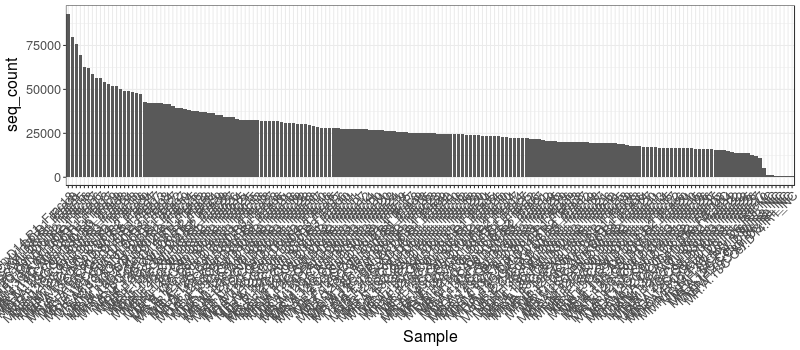

In [34]:
%%R -i df_seq_cnt -w 800 -h 350
# plotting all

df_seq_cnt$seq_count = as.numeric(df_seq_cnt$seq_count)


df_seq_cnt = df_seq_cnt %>% 
    #mutate(H2O = grepl('_F0$', Sample)) %>%
    mutate(rank = min_rank(seq_count)) %>%
    arrange(desc(rank))

df_seq_cnt$Sample = factor(df_seq_cnt$Sample, levels=df_seq_cnt$Sample)

ggplot(df_seq_cnt, aes(Sample, seq_count)) +
    geom_bar(stat='identity') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x = element_text(angle=45, hjust=1)
    )

In [35]:
%%R
df_seq_cnt[df_seq_cnt$seq_count < 10000,]

                       Sample seq_count rank
174 MR.F.13C-Xyl.D3.R1_Frac10      5170    8
175     MR.M.13C-Ami.D6.R1_NC      1131    7
176     MR.F.13C-Xyl.D6.R1_NC      1044    6
177    MR.A.13C-Pal.D30.R3_NC      1011    5
178    MR.A.12C-Con.D30.R3_NC       818    4
179     MR.M.12C-Con.D6.R2_NC       665    3
180     MR.F.13C-Xyl.D3.R1_NC       627    2
181    MR.A.13C-Cel.D14.R1_NC       593    1
